In [6]:
import pandas as pd
import numpy as np
import requests
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score

In [7]:
AQICN_TOKEN = "db81fc42c61c3ed75bf2a98c285470286fc8da51"
VISUAL_CROSSING_KEY = "4SD5JP775G8EFDF9T5HV7KF2B"

In [8]:
df1 = pd.read_excel("../Data/Alias Karyawan.xlsx")
df2 = pd.read_excel("../Data/Dummy Medical Data.xlsx")

df1.columns = df1.columns.str.strip()
df2.columns = df2.columns.str.strip()

df2['EXCESS NOT PAID'] = df2['EXCESS NOT PAID'].fillna(0).astype(float)
df2['EXCESS PAID'] = df2['EXCESS PAID'].fillna(0).astype(float)
df2['ALIAS_PATIENT'] = df2['ALIAS_PATIENT'].fillna("UNKNOWN")

if not df1['Level'].mode().empty:
    df1['Level'] = df1['Level'].fillna(df1['Level'].mode()[0])

In [9]:
location_coords = {
    "Kantor Pusat": (-6.1118, 106.8828),
    "Perak Barat": (-7.2159, 112.7224),
    "Kalianak": (-7.2254, 112.6949),
    "Cabang Jakarta": (-6.1115, 106.8912),
    "SPIL Ventures Jakarta": (-6.2248, 106.8107),
    "Cabang Sampit": (-2.5541, 112.9500),
    "DFF Surabaya": (-7.2223, 112.7320),
    "Depo Tanjung Batu 4": (-7.2219, 112.7235),
    "DFF Jakarta": (-6.1085, 106.8859),
    "NSI Jakarta": (-6.1164, 106.8947),
    "Depo Tambak Langon": (-7.2230, 112.6617),
    "Cabang Balikpapan": (-1.2788, 116.8193),
    "Cabang Banjarmasin": (-3.3529, 114.5762),
    "SPIL TOLL Jakarta": (-6.1764, 106.8155),
    "LCE Surabaya": (-7.2224, 112.7320)
}

name_to_location = df1.set_index("Name")["Location"].to_dict()
df2["Office Location"] = df2["ALIAS_PATIENT"].map(name_to_location)

df2 = df2.dropna(subset=["Office Location"]).reset_index(drop=True)
df2["lat"] = df2["Office Location"].map(lambda x: location_coords.get(x, (None, None))[0])
df2["lon"] = df2["Office Location"].map(lambda x: location_coords.get(x, (None, None))[1])

In [10]:
df2["ADMISSION_DATE"] = pd.to_datetime(df2["ADMISSION_DATE"], errors="coerce", format="%m/%d/%Y")
df2["DISCHARGEABLE_DATE"] = pd.to_datetime(df2["DISCHARGEABLE_DATE"], errors="coerce")

df2 = df2[df2["ADMISSION_DATE"] >= "2024-07-01"].reset_index(drop=True)

In [11]:
def get_weather(lat, lon, date):
    url = f"https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/{lat},{lon}/{date}?unitGroup=metric&key={VISUAL_CROSSING_KEY}&include=days"
    try:
        r = requests.get(url, timeout=10)
        if r.status_code != 200:
            return None, None, None, None
        data = r.json()
        day = data.get("days", [{}])[0]
        return (
            day.get("tempmin"),
            day.get("tempmax"),
            day.get("temp"),
            day.get("conditions")
        )
    except:
        return None, None, None, None

def get_air_quality(lat, lon):
    url = f"https://api.waqi.info/feed/geo:{lat};{lon}/?token={AQICN_TOKEN}"
    try:
        r = requests.get(url, timeout=10)
        if r.status_code != 200:
            return None
        data = r.json()
        return data.get("data", {}).get("aqi", None)
    except:
        return None

weather_cache = {}
air_cache = {}

df2["min_temp"] = np.nan
df2["max_temp"] = np.nan
df2["avg_temp"] = np.nan
df2["weather_con"] = np.nan
df2["air_qual"] = np.nan

for i, row in df2.iterrows():
    lat, lon, date = row["lat"], row["lon"], row["ADMISSION_DATE"]
    if pd.isna(lat) or pd.isna(lon) or pd.isna(date):
        continue
    
    date_str = date.strftime("%Y-%m-%d")
    cache_key = (lat, lon, date_str)

    if cache_key not in weather_cache:
        weather_cache[cache_key] = get_weather(lat, lon, date_str)
    min_t, max_t, avg_t, cond = weather_cache[cache_key]

    if (lat, lon) not in air_cache:
        air_cache[(lat, lon)] = get_air_quality(lat, lon)
    air_q = air_cache[(lat, lon)]

    df2.at[i, "min_temp"] = min_t
    df2.at[i, "max_temp"] = max_t
    df2.at[i, "avg_temp"] = avg_t
    df2.at[i, "weather_con"] = cond
    df2.at[i, "air_qual"] = air_q

/tmp/ipykernel_3643/2706491835.py:57: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Rain, Partially cloudy' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df2.at[i, "weather_con"] = cond


In [12]:
df2['DURATION_STAY'] = (df2['DISCHARGEABLE_DATE'] - df2['ADMISSION_DATE']).dt.days

threshold = df2.groupby('ADMISSION_DATE').size().median()
daily_cases = df2.groupby('ADMISSION_DATE').size().rename('daily_cases')
df2 = df2.merge(daily_cases, on='ADMISSION_DATE')
df2['HIGH_RISK'] = (df2['daily_cases'] > threshold).astype(int)

In [13]:
features = [
    "PROVIDER", "MEMBER_TYPE", "DURATION_STAY", "DIAGNOSIS DESC", "DUE_TOTAL", "APPROVE",
    "STATUS", "COVERAGE_ID", "Office Location", "lat", "lon",
    "min_temp", "max_temp", "avg_temp", "weather_con", "air_qual"
]

X = df2[features]
y = df2["HIGH_RISK"]

categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()

In [14]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numerical_cols),
        
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), categorical_cols)
    ]
)

In [15]:
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(
        n_estimators=300,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        use_label_encoder=False,
        eval_metric="logloss"
    ))
])

/home/lucafivan/Documents/INTERNSHIP/intern/lib/python3.13/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

scores = cross_val_score(model, X, y, cv=5, scoring="roc_auc")
print("CV ROC AUC mean:", scores.mean())

              precision    recall  f1-score   support

           0       0.65      0.55      0.59        20
           1       0.72      0.79      0.75        29

    accuracy                           0.69        49
   macro avg       0.68      0.67      0.67        49
weighted avg       0.69      0.69      0.69        49

ROC AUC: 0.706896551724138


/home/lucafivan/Documents/INTERNSHIP/intern/lib/python3.13/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/home/lucafivan/Documents/INTERNSHIP/intern/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucafivan/Documents/INTERNSHIP/intern/lib/python3.13/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
        cached_call, estimator, *args, **routed_params.get(name).score
    )
  File "/home/lucafivan/Documents/INTERNSHIP/intern/lib/python3.13/site-packages/sklearn/metrics/_scorer.py", line 400, in _score
    y_pred = method_caller(
        estimator,
    ...<2 lines>...
        pos_label=pos_label,
    )
  File "/home/lucafivan/Documents/INTERNSHI

CV ROC AUC mean: nan


/home/lucafivan/Documents/INTERNSHIP/intern/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lucafivan/Documents/INTERNSHIP/intern/lib/python3.13/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
        cached_call, estimator, *args, **routed_params.get(name).score
    )
  File "/home/lucafivan/Documents/INTERNSHIP/intern/lib/python3.13/site-packages/sklearn/metrics/_scorer.py", line 400, in _score
    y_pred = method_caller(
        estimator,
    ...<2 lines>...
        pos_label=pos_label,
    )
  File "/home/lucafivan/Documents/INTERNSHIP/intern/lib/python3.13/site-packages/sklearn/metrics/_scorer.py", line 90, in _cached_call
    result, _ = _get_response_values(
                ~~~~~~~~~~~~~~~~~~~~^
        estimator, *args, response_method=response

In [17]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score


In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [19]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=200, random_state=42),
    "Random Forest": RandomForestClassifier(
        n_estimators=200, max_depth=8, random_state=42
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=200, learning_rate=0.05, max_depth=3, random_state=42
    )
}

In [20]:
for name, clf in models.items():
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("classifier", clf)
    ])
    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:,1]
    
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_proba))
    
    scores = cross_val_score(pipe, X, y, cv=5, scoring="roc_auc")
    print("CV ROC AUC mean:", scores.mean())


=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.53      0.45      0.49        20
           1       0.66      0.72      0.69        29

    accuracy                           0.61        49
   macro avg       0.59      0.59      0.59        49
weighted avg       0.60      0.61      0.61        49

ROC AUC: 0.6689655172413793
CV ROC AUC mean: 0.4361975134881539

=== Random Forest ===
              precision    recall  f1-score   support

           0       0.60      0.30      0.40        20
           1       0.64      0.86      0.74        29

    accuracy                           0.63        49
   macro avg       0.62      0.58      0.57        49
weighted avg       0.62      0.63      0.60        49

ROC AUC: 0.6948275862068966
CV ROC AUC mean: 0.46560579404175473

=== Gradient Boosting ===
              precision    recall  f1-score   support

           0       0.38      0.25      0.30        20
           1       0.58      

In [21]:
df2.head()

,PAYOR_CODE,PROVIDER,PROVIDER NAME,CLAIMS_ID,ALIAS_PATIENT,CARD NO,MEMBER_TYPE,ALIAS_PRINCIPLE,POLICY NO,ADMISSION_DATE,...,lat,lon,min_temp,max_temp,avg_temp,weather_con,air_qual,DURATION_STAY,daily_cases,HIGH_RISK
0,INTRA,2315 NATIONAL HOSPITAL SURABAYA,2315 NATIONAL HOSPITAL SURABAYA,135691521,Alyssa Flynn,8000195200362953,P,Alyssa Flynn,GP3213012400265,2024-07-09,...,-6.1118,106.8828,24.3,31.7,28.2,"Rain, Partially cloudy",132.0,0,1,0
1,INTRA,0748 RS GADING PLUIT,0748 RS GADING PLUIT,135793578,Kailani Good,8000195200374891,P,Kailani Good,GP3213012400265,2024-07-13,...,-6.1115,106.8912,22.6,32.7,28.0,Partially cloudy,132.0,0,2,1
2,INTRA,0895 RS PHC SURABAYA,0895 RS PHC SURABAYA,135865854,Khalil Galindo,8000195200363514,P,Khalil Galindo,GP3213012400265,2024-07-16,...,-6.1118,106.8828,23.3,33.4,28.5,Partially cloudy,132.0,0,3,1
3,INTRA,0895 RS PHC SURABAYA,0895 RS PHC SURABAYA,135873315,Khalil Galindo,8000195200363514,P,Khalil Galindo,GP3213012400265,2024-07-16,...,-6.1118,106.8828,23.3,33.4,28.5,Partially cloudy,132.0,0,3,1
4,INTRA,2217 RS KENDANG SARI SURABAYA,2217 RS KENDANG SARI SURABAYA,135908548,April Bean,8000195200362383,D,Bryson Davidson,GP3213012400265,2024-07-18,...,-7.2159,112.7224,23.0,32.0,27.5,Partially cloudy,30.0,0,3,1


In [22]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 32 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   PAYOR_CODE          244 non-null    object        
 1   PROVIDER            244 non-null    object        
 2   PROVIDER NAME       244 non-null    object        
 3   CLAIMS_ID           244 non-null    int64         
 4   ALIAS_PATIENT       244 non-null    object        
 5   CARD NO             244 non-null    int64         
 6   MEMBER_TYPE         244 non-null    object        
 7   ALIAS_PRINCIPLE     244 non-null    object        
 8   POLICY NO           244 non-null    object        
 9   ADMISSION_DATE      244 non-null    datetime64[ns]
 10  DISCHARGEABLE_DATE  244 non-null    datetime64[ns]
 11  CORP NAME           244 non-null    object        
 12  CLAIMS_STATUS       244 non-null    int64         
 13  DIAGNOSIS DESC      244 non-null    object        

In [ ]:
import pandas as pd
import requests

AQICN_TOKEN = "db81fc42c61c3ed75bf2a98c285470286fc8da51"
VISUAL_CROSSING_KEY = "4SD5JP775G8EFDF9T5HV7KF2B"

df1 = pd.read_excel("../Data/Alias Karyawan.xlsx")
df2 = pd.read_excel("../Data/Dummy Medical Data.xlsx")

df1.columns = df1.columns.str.strip()
df2.columns = df2.columns.str.strip()

df2['EXCESS NOT PAID'] = df2['EXCESS NOT PAID'].fillna(0).astype(float)
df2['EXCESS PAID'] = df2['EXCESS PAID'].fillna(0).astype(float)
df2['ALIAS_PATIENT'] = df2['ALIAS_PATIENT'].fillna("UNKNOWN")

if not df1['Level'].mode().empty:
    most_common_level = df1['Level'].mode()[0]
    df1['Level'] = df1['Level'].fillna(most_common_level)

location_coords = {
    "Kantor Pusat": (-6.111794260284162, 106.88283733063057),
    "Perak Barat": (-7.2158819131542655, 112.72238446891035),
    "Kalianak": (-7.2253644346702615, 112.69488138880472),
    "Cabang Jakarta": (-6.1114513303634395, 106.89119653545708),
    "SPIL Ventures Jakarta": (-6.224782056086383, 106.8107458942324),
    "Cabang Sampit": (-2.5541082792051997, 112.95003578071079),
    "DFF Surabaya": (-7.222332908294212, 112.73200116382841),
    "Depo Tanjung Batu 4": (-7.2219069287441435, 112.72354683565548),
    "DFF Jakarta": (-6.108546859718195, 106.88594087131685),
    "NSI Jakarta": (-6.1163952499304886, 106.89469550420228),
    "Depo Tambak Langon": (-7.2229543544800565, 112.66168686739654),
    "Cabang Balikpapan": (-1.2788076347126114, 116.81932182955545),
    "Cabang Banjarmasin": (-3.352921394510907, 114.57622741323114),
    "SPIL TOLL Jakarta": (-6.176378348853989, 106.81554823247686),
    "LCE Surabaya": (-7.222418057972876, 112.73200116382837)
}

name_to_location = df1.set_index("Name")["Location"].to_dict()
df2["Office Location"] = df2["ALIAS_PATIENT"].map(name_to_location)

df2 = df2.dropna(subset=["Office Location"]).reset_index(drop=True)

df2["lat"] = df2["Office Location"].map(lambda x: location_coords.get(x, (None, None))[0])
df2["lon"] = df2["Office Location"].map(lambda x: location_coords.get(x, (None, None))[1])

df2["ADMISSION_DATE"] = pd.to_datetime(df2["ADMISSION_DATE"], errors="coerce", format="%m/%d/%Y")

df2 = df2[df2["ADMISSION_DATE"] >= "2024-07-01"].reset_index(drop=True)
print(f"Jumlah baris setelah filter: {len(df2)}")

df2["min_temp"] = None
df2["max_temp"] = None
df2["avg_temp"] = None
df2["weather_con"] = None
df2["air_qual"] = None

def get_weather(lat, lon, date):
    url = f"https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/{lat},{lon}/{date}?unitGroup=metric&key={VISUAL_CROSSING_KEY}&include=days"
    try:
        r = requests.get(url, timeout=10)
        if r.status_code != 200:
            return None, None, None, None
        data = r.json()
        day = data.get("days", [{}])[0]
        return (
            day.get("tempmin"),
            day.get("tempmax"),
            day.get("temp"),
            day.get("conditions")
        )
    except:
        return None, None, None, None

def get_air_quality(lat, lon):
    url = f"https://api.waqi.info/feed/geo:{lat};{lon}/?token={AQICN_TOKEN}"
    try:
        r = requests.get(url, timeout=10)
        if r.status_code != 200:
            return None
        data = r.json()
        return data.get("data", {}).get("aqi", None)
    except:
        return None

weather_cache = {}
air_cache = {}

for i, row in df2.iterrows():
    lat, lon, date = row["lat"], row["lon"], row["ADMISSION_DATE"]
    if pd.isna(lat) or pd.isna(lon) or pd.isna(date):
        continue
    
    date_str = date.strftime("%Y-%m-%d")
    cache_key = (lat, lon, date_str)

    if cache_key not in weather_cache:
        weather_cache[cache_key] = get_weather(lat, lon, date_str)
    min_t, max_t, avg_t, cond = weather_cache[cache_key]

    if (lat, lon) not in air_cache:
        air_cache[(lat, lon)] = get_air_quality(lat, lon)
    air_q = air_cache[(lat, lon)]

    df2.at[i, "min_temp"] = min_t
    df2.at[i, "max_temp"] = max_t
    df2.at[i, "avg_temp"] = avg_t
    df2.at[i, "weather_con"] = cond
    df2.at[i, "air_qual"] = air_q


Jumlah baris setelah filter: 244
  PAYOR_CODE                                          PROVIDER  \
0      INTRA         2315           NATIONAL HOSPITAL SURABAYA   
1      INTRA                    0748           RS GADING PLUIT   
2      INTRA                    0895           RS PHC SURABAYA   
3      INTRA                    0895           RS PHC SURABAYA   
4      INTRA           2217           RS KENDANG SARI SURABAYA   
5      INTRA                    0895           RS PHC SURABAYA   
6      INTRA                    0895           RS PHC SURABAYA   
7      INTRA           2217           RS KENDANG SARI SURABAYA   
8      INTRA          6383           AUDY DENTAL KELAPA GADING   
9      INTRA  0544           RS ST VINCENTIUS A PAULO (RS RKZ)   

                            PROVIDER NAME  CLAIMS_ID   ALIAS_PATIENT  \
0         2315 NATIONAL HOSPITAL SURABAYA  135691521    Alyssa Flynn   
1                    0748 RS GADING PLUIT  135793578    Kailani Good   
2                    089

In [ ]:
display(df2.head(10))

,PAYOR_CODE,PROVIDER,PROVIDER NAME,CLAIMS_ID,ALIAS_PATIENT,CARD NO,MEMBER_TYPE,ALIAS_PRINCIPLE,POLICY NO,ADMISSION_DATE,...,STATUS,COVERAGE_ID,Office Location,lat,lon,min_temp,max_temp,avg_temp,weather_con,air_qual
0,INTRA,2315 NATIONAL HOSPITAL SURABAYA,2315 NATIONAL HOSPITAL SURABAYA,135691521,Alyssa Flynn,8000195200362953,P,Alyssa Flynn,GP3213012400265,2024-07-09,...,OUT PATIENT,GP,Kantor Pusat,-6.111794,106.882837,24.3,31.7,28.2,"Rain, Partially cloudy",18
1,INTRA,0748 RS GADING PLUIT,0748 RS GADING PLUIT,135793578,Kailani Good,8000195200374891,P,Kailani Good,GP3213012400265,2024-07-13,...,OUT PATIENT,GP,Cabang Jakarta,-6.111451,106.891197,22.6,32.7,28.0,Partially cloudy,18
2,INTRA,0895 RS PHC SURABAYA,0895 RS PHC SURABAYA,135865854,Khalil Galindo,8000195200363514,P,Khalil Galindo,GP3213012400265,2024-07-16,...,OUT PATIENT,GP,Kantor Pusat,-6.111794,106.882837,23.3,33.4,28.5,Partially cloudy,18
3,INTRA,0895 RS PHC SURABAYA,0895 RS PHC SURABAYA,135873315,Khalil Galindo,8000195200363514,P,Khalil Galindo,GP3213012400265,2024-07-16,...,OUT PATIENT,GP,Kantor Pusat,-6.111794,106.882837,23.3,33.4,28.5,Partially cloudy,18
4,INTRA,2217 RS KENDANG SARI SURABAYA,2217 RS KENDANG SARI SURABAYA,135908548,April Bean,8000195200362383,D,Bryson Davidson,GP3213012400265,2024-07-18,...,OUT PATIENT,GP,Perak Barat,-7.215882,112.722384,23.0,32.0,27.5,Partially cloudy,2
5,INTRA,0895 RS PHC SURABAYA,0895 RS PHC SURABAYA,135908893,Khalil Galindo,8000195200363514,P,Khalil Galindo,GP3213012400265,2024-07-18,...,OUT PATIENT,GP,Kantor Pusat,-6.111794,106.882837,25.3,32.8,29.2,Partially cloudy,18
6,INTRA,0895 RS PHC SURABAYA,0895 RS PHC SURABAYA,135910559,Khalil Galindo,8000195200363514,P,Khalil Galindo,GP3213012400265,2024-07-18,...,OUT PATIENT,GP,Kantor Pusat,-6.111794,106.882837,25.3,32.8,29.2,Partially cloudy,18
7,INTRA,2217 RS KENDANG SARI SURABAYA,2217 RS KENDANG SARI SURABAYA,135930768,April Bean,8000195200362383,D,Bryson Davidson,GP3213012400265,2024-07-19,...,OUT PATIENT,GP,Perak Barat,-7.215882,112.722384,23.0,32.6,27.6,Partially cloudy,2
8,INTRA,6383 AUDY DENTAL KELAPA GADING,6383 AUDY DENTAL KELAPA GADING,136012725,Alyssa Flynn,8000195200363860,P,Alyssa Flynn,GP3213012400265,2024-07-22,...,DENTAL,DENTAL,Kantor Pusat,-6.111794,106.882837,25.3,32.7,29.2,Partially cloudy,18
9,INTRA,0544 RS ST VINCENTIUS A PAULO (RS RKZ),0544 RS ST VINCENTIUS A PAULO (RS RKZ),136029486,Axl Tran,8000195200363712,P,Axl Tran,GP3213012400265,2024-07-23,...,OUT PATIENT,GP,Perak Barat,-7.215882,112.722384,22.0,33.0,27.6,Partially cloudy,2


In [ ]:
display(df1.head(10))

,Name,Department,Location,Division,Position,Level
0,Tate Phan,Insurance & Claim Department,Perak Barat,Human Capital & Corporate Affairs Division,Insurance Sales & Claim Manager,Middle Manager
1,Milani Hanson,Heavy Equipment Department,Kalianak,Operation Division,Heavy Equipment Maintenance & Repair Branch As...,Junior Manager
2,Alaina Ross,National Sales Department,Perak Barat,Commercial Division,Regional Sales Manager,Middle Manager
3,Mila Ray,DPA Department,Kalianak,Fleet Division,DPA Assistant,Junior Manager
4,Lena Whitehead,Nautical Department,Kalianak,Fleet Division,Nautical Advisor,Junior Manager
5,Natalia Munoz,Internal Audit Department,Kantor Pusat,Internal Audit,Junior Manager,Junior Manager
6,Axl Tran,Strategy Development And Implementation Depart...,Perak Barat,Strategy Development And Implementation Division,Process Improvement Assistant Manager,Junior Manager
7,Brooklyn Mercado,Fleet Department,Kalianak,Fleet Division,Middle Manager,Junior Manager
8,Jaxson Schroeder,Chinese Desk,Cabang Jakarta,BOD,Chinese Desk Assistant Manager,Junior Manager
9,Anne Randolph,Human Capital & Corporate Affairs Jakarta Depa...,Cabang Jakarta,Operation Division,Project & Building Maintenance Assistant Manager,Junior Manager


In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151 entries, 0 to 150
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Name        151 non-null    object
 1   Department  151 non-null    object
 2   Location    151 non-null    object
 3   Division    151 non-null    object
 4   Position    151 non-null    object
 5   Level       151 non-null    object
dtypes: object(6)
memory usage: 7.2+ KB


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 29 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   PAYOR_CODE          244 non-null    object        
 1   PROVIDER            244 non-null    object        
 2   PROVIDER NAME       244 non-null    object        
 3   CLAIMS_ID           244 non-null    int64         
 4   ALIAS_PATIENT       244 non-null    object        
 5   CARD NO             244 non-null    int64         
 6   MEMBER_TYPE         244 non-null    object        
 7   ALIAS_PRINCIPLE     244 non-null    object        
 8   POLICY NO           244 non-null    object        
 9   ADMISSION_DATE      244 non-null    datetime64[ns]
 10  DISCHARGEABLE_DATE  244 non-null    datetime64[ns]
 11  CORP NAME           244 non-null    object        
 12  CLAIMS_STATUS       244 non-null    int64         
 13  DIAGNOSIS DESC      244 non-null    object        

In [ ]:
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df1_encoded = df1.copy()
df2_encoded = df2.copy()

In [ ]:
def encode_and_corr(df, df_name="DataFrame"):
    df_encoded = df.copy()
    
    numerical_cols = df_encoded.select_dtypes(include=["int64", "float64"]).columns.tolist()
    categorical_cols = df_encoded.select_dtypes(include=["object"]).columns.tolist()
    
    print(f"\n=== {df_name} ===")
    print("Numerical cols:", numerical_cols)
    print("Categorical cols:", categorical_cols)
    
    le_dict = {}
    for col in categorical_cols:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
        le_dict[col] = le  
    
    corr_matrix = df_encoded.corr()
    
    plt.figure(figsize=(12,10))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title(f"Correlation Matrix - {df_name}")
    plt.show()
    
    return df_encoded, corr_matrix, le_dict


=== df1 ===
Numerical cols: []
Categorical cols: ['Name', 'Department', 'Location', 'Division', 'Position', 'Level']


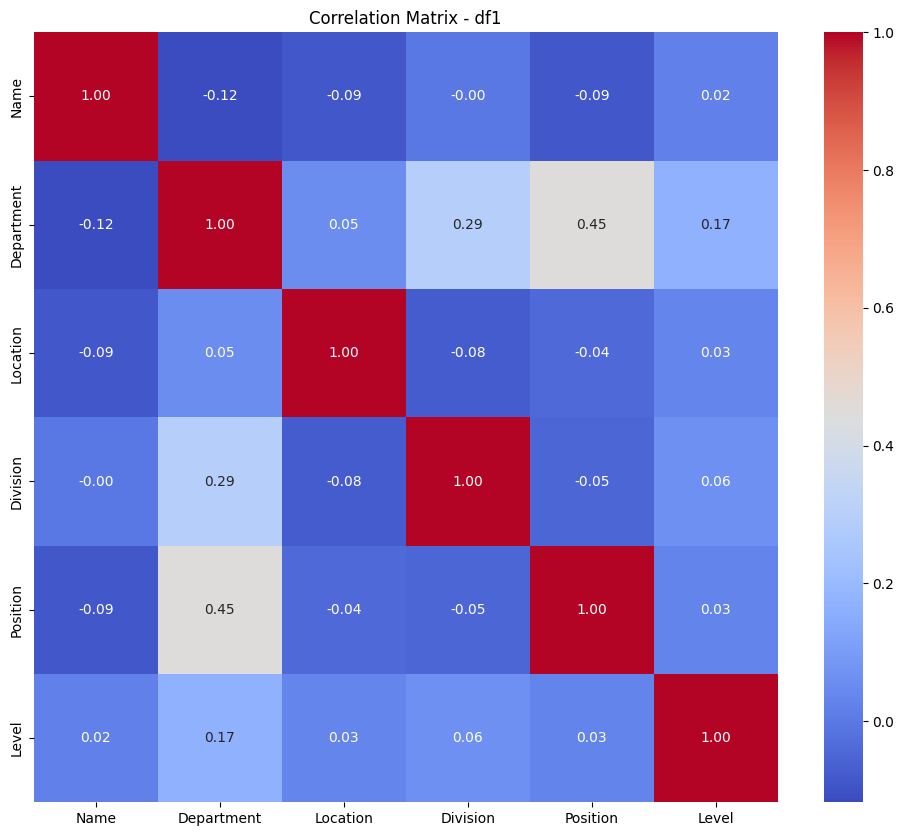

In [ ]:
df1_encoded, df1_corr, df1_le = encode_and_corr(df1, "df1")


=== df2 ===
Numerical cols: ['CLAIMS_ID', 'CARD NO', 'CLAIMS_STATUS', 'DUE_TOTAL', 'APPROVE', 'MEMBER PAY', 'EXCESS PAID', 'EXCESS NOT PAID', 'lat', 'lon']
Categorical cols: ['PAYOR_CODE', 'PROVIDER', 'PROVIDER NAME', 'ALIAS_PATIENT', 'MEMBER_TYPE', 'ALIAS_PRINCIPLE', 'POLICY NO', 'CORP NAME', 'DIAGNOSIS DESC', 'STATUS', 'COVERAGE_ID', 'Office Location', 'min_temp', 'max_temp', 'avg_temp', 'weather_con', 'air_qual']


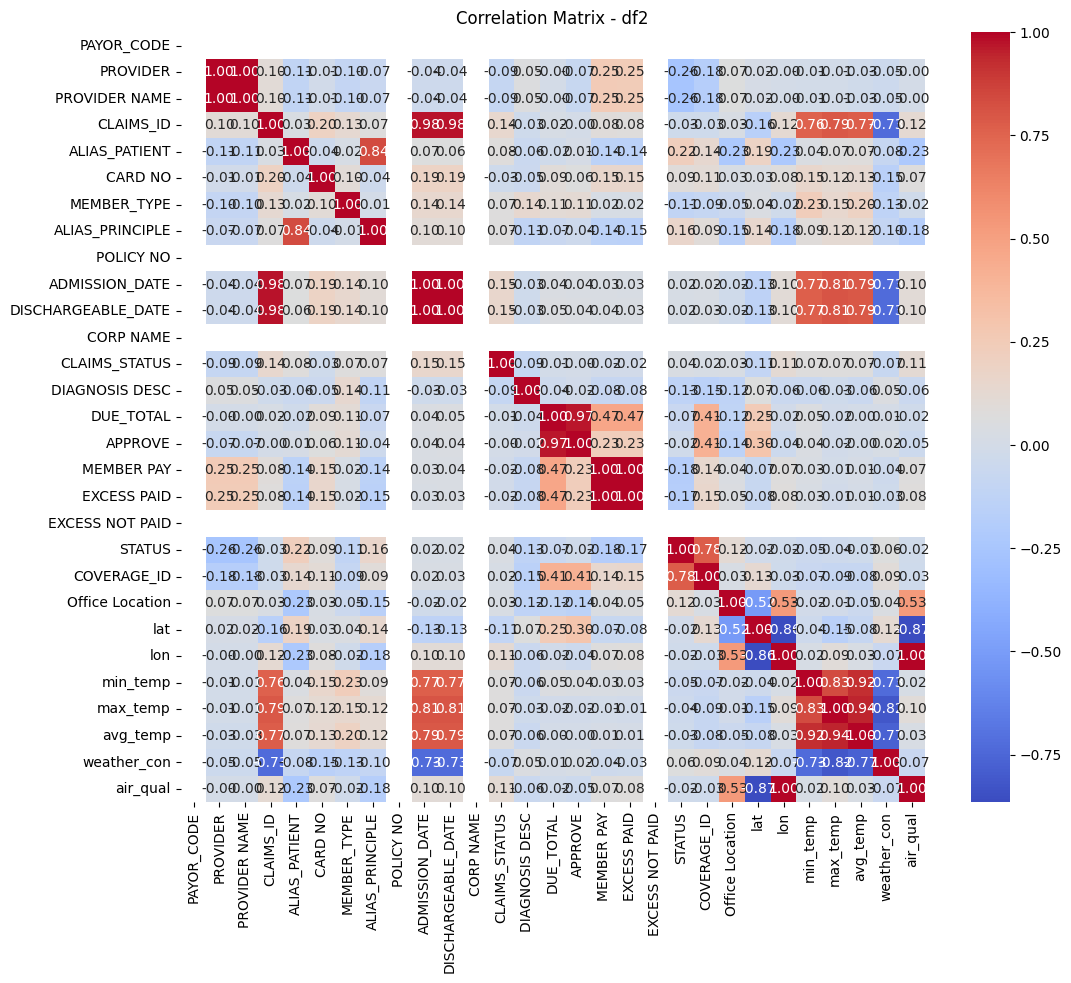

In [ ]:
df2_encoded, df2_corr, df2_le = encode_and_corr(df2, "df2")

In [ ]:
df2['ADMISSION_DATE'] = pd.to_datetime(df2['ADMISSION_DATE'])
df2['DISCHARGEABLE_DATE'] = pd.to_datetime(df2['DISCHARGEABLE_DATE'])

df2['DURATION_STAY'] = (df2['DISCHARGEABLE_DATE'] - df2['ADMISSION_DATE']).dt.days

In [ ]:
threshold = df2.groupby('ADMISSION_DATE').size().median()  
daily_cases = df2.groupby('ADMISSION_DATE').size().rename('daily_cases')
df2 = df2.merge(daily_cases, on='ADMISSION_DATE')
df2['HIGH_RISK'] = (df2['daily_cases'] > threshold).astype(int)

In [ ]:
features = [
    "PROVIDER", "MEMBER_TYPE", "DURATION_STAY", "DIAGNOSIS DESC", "DUE_TOTAL", "APPROVE",
    "STATUS", "COVERAGE_ID", "Office Location", "lat", "lon", "min_temp", "max_temp",
    "avg_temp", "weather_con", "air_qual"
]
X = df2[features]
y = df2['HIGH_RISK']

In [ ]:
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()

In [ ]:
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [ ]:
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

/home/lucafivan/Documents/INTERNSHIP/intern/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [15:25:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  if cb_container.before_iteration(bst, i, dtrain, evals):


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [ ]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.42      0.47      0.44        17
           1       0.70      0.66      0.68        32

    accuracy                           0.59        49
   macro avg       0.56      0.56      0.56        49
weighted avg       0.60      0.59      0.60        49

ROC AUC: 0.5533088235294117


In [28]:
df2.head()

,PAYOR_CODE,PROVIDER,PROVIDER NAME,CLAIMS_ID,ALIAS_PATIENT,CARD NO,MEMBER_TYPE,ALIAS_PRINCIPLE,POLICY NO,ADMISSION_DATE,...,lat,lon,min_temp,max_temp,avg_temp,weather_con,air_qual,DURATION_STAY,daily_cases,HIGH_RISK
0,INTRA,2315 NATIONAL HOSPITAL SURABAYA,2315 NATIONAL HOSPITAL SURABAYA,135691521,Alyssa Flynn,8000195200362953,P,Alyssa Flynn,GP3213012400265,2024-07-09,...,-6.1118,106.8828,24.3,31.7,28.2,"Rain, Partially cloudy",132.0,0,1,0
1,INTRA,0748 RS GADING PLUIT,0748 RS GADING PLUIT,135793578,Kailani Good,8000195200374891,P,Kailani Good,GP3213012400265,2024-07-13,...,-6.1115,106.8912,22.6,32.7,28.0,Partially cloudy,132.0,0,2,1
2,INTRA,0895 RS PHC SURABAYA,0895 RS PHC SURABAYA,135865854,Khalil Galindo,8000195200363514,P,Khalil Galindo,GP3213012400265,2024-07-16,...,-6.1118,106.8828,23.3,33.4,28.5,Partially cloudy,132.0,0,3,1
3,INTRA,0895 RS PHC SURABAYA,0895 RS PHC SURABAYA,135873315,Khalil Galindo,8000195200363514,P,Khalil Galindo,GP3213012400265,2024-07-16,...,-6.1118,106.8828,23.3,33.4,28.5,Partially cloudy,132.0,0,3,1
4,INTRA,2217 RS KENDANG SARI SURABAYA,2217 RS KENDANG SARI SURABAYA,135908548,April Bean,8000195200362383,D,Bryson Davidson,GP3213012400265,2024-07-18,...,-7.2159,112.7224,23.0,32.0,27.5,Partially cloudy,30.0,0,3,1


In [ ]:
df2.isnull().sum()

PAYOR_CODE              0
PROVIDER                0
PROVIDER NAME           0
CLAIMS_ID               0
ALIAS_PATIENT           0
CARD NO                 0
MEMBER_TYPE             0
ALIAS_PRINCIPLE         0
POLICY NO               0
ADMISSION_DATE          0
DISCHARGEABLE_DATE      0
CORP NAME               0
CLAIMS_STATUS           0
DIAGNOSIS DESC          0
DUE_TOTAL               0
APPROVE                 0
MEMBER PAY              0
EXCESS PAID             0
EXCESS NOT PAID         0
STATUS                  0
COVERAGE_ID             0
Office Location         0
lat                     0
lon                     0
min_temp              135
max_temp              135
avg_temp              135
weather_con           135
air_qual                0
DURATION_STAY           0
daily_cases             0
HIGH_RISK               0
dtype: int64

In [24]:
df2.isnull().sum()

PAYOR_CODE            0
PROVIDER              0
PROVIDER NAME         0
CLAIMS_ID             0
ALIAS_PATIENT         0
CARD NO               0
MEMBER_TYPE           0
ALIAS_PRINCIPLE       0
POLICY NO             0
ADMISSION_DATE        0
DISCHARGEABLE_DATE    0
CORP NAME             0
CLAIMS_STATUS         0
DIAGNOSIS DESC        0
DUE_TOTAL             0
APPROVE               0
MEMBER PAY            0
EXCESS PAID           0
EXCESS NOT PAID       0
STATUS                0
COVERAGE_ID           0
Office Location       0
lat                   0
lon                   0
min_temp              1
max_temp              1
avg_temp              1
weather_con           1
air_qual              0
DURATION_STAY         0
daily_cases           0
HIGH_RISK             0
dtype: int64

In [25]:
num_cols = df2[features].select_dtypes(include=["int64", "float64"]).columns

num_corr = df2[num_cols].corrwith(df2["HIGH_RISK"]).sort_values(ascending=False)
print("\n=== Korelasi Numerik dengan HIGH_RISK ===")
print(num_corr)


=== Korelasi Numerik dengan HIGH_RISK ===
max_temp         0.120092
lat              0.085366
avg_temp         0.075481
air_qual         0.064600
DURATION_STAY    0.039216
APPROVE          0.017403
DUE_TOTAL       -0.003339
min_temp        -0.031610
lon             -0.062218
dtype: float64


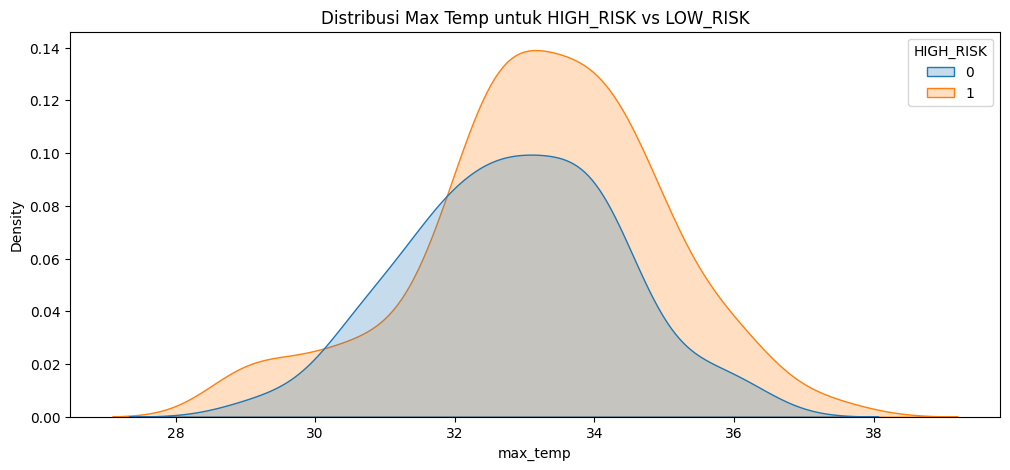

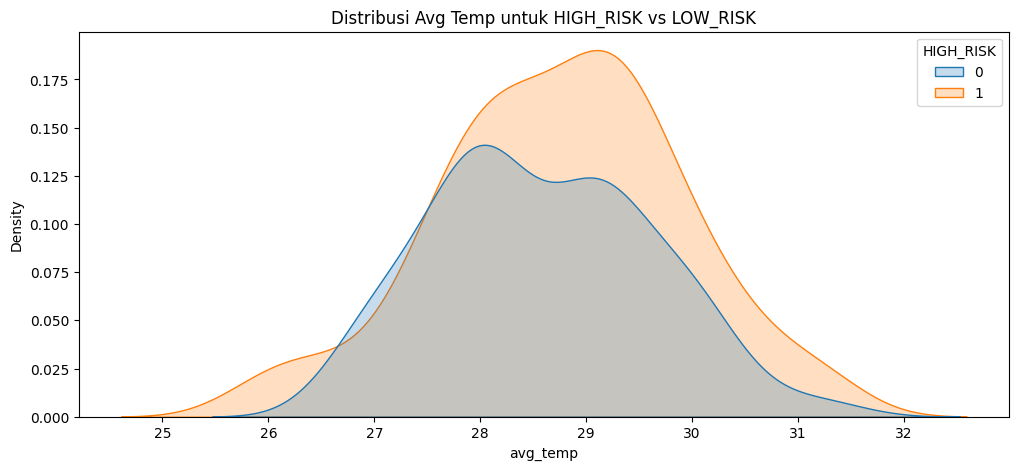

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
sns.kdeplot(data=df2, x="max_temp", hue="HIGH_RISK", fill=True)
plt.title("Distribusi Max Temp untuk HIGH_RISK vs LOW_RISK")
plt.show()

plt.figure(figsize=(12,5))
sns.kdeplot(data=df2, x="avg_temp", hue="HIGH_RISK", fill=True)
plt.title("Distribusi Avg Temp untuk HIGH_RISK vs LOW_RISK")
plt.show()

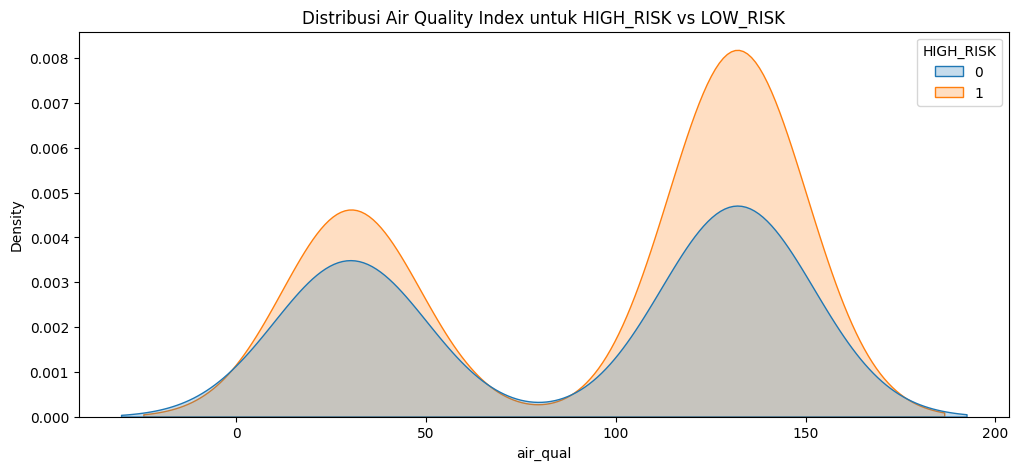

In [30]:
plt.figure(figsize=(12,5))
sns.kdeplot(data=df2, x="air_qual", hue="HIGH_RISK", fill=True)
plt.title("Distribusi Air Quality Index untuk HIGH_RISK vs LOW_RISK")
plt.show()


In [31]:
from sklearn.preprocessing import LabelEncoder

df2_weather = df2.copy()
df2_weather["weather_con_enc"] = LabelEncoder().fit_transform(df2_weather["weather_con"].astype(str))

weather_risk = df2_weather.groupby("weather_con")["HIGH_RISK"].mean().sort_values(ascending=False)
print("\n=== Persentase HIGH_RISK per Weather Condition ===")
print(weather_risk)


=== Persentase HIGH_RISK per Weather Condition ===
weather_con
Partially cloudy          0.663934
Rain, Partially cloudy    0.504132
Name: HIGH_RISK, dtype: float64
